# Predicting bike rentals

Many cities worldwide have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

[Hadi Fanaee-T](http://www.fanaee.com/) at the University of Porto compiled this data into a CSV file, which we worked with in this project. The file contains `17380` rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

Our goal for this project was to predict the number of bike rents for each hour using machine learning algorithms given the available set of features. In the end, random forests regressor turned out to be the most accurate algorithm for a given task.

## Data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
bikerent = pd.read_csv('bike_rental_hour.csv', index_col='instant')
bikerent

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90


Here are the descriptions for the relevant columns:

* instant - A unique sequential ID number for each row
* dteday - The date of the rentals
* season - The season in which the rentals occurred
* yr - The year the rentals occurred
* mnth - The month the rentals occurred
* hr - The hour the rentals occurred
* holiday - Whether or not the day was a holiday
* weekday - The day of the week (as a number, 0 to 7)
* workingday - Whether or not the day was a working day
* weathersit - The weather (as a categorical variable)
* temp - The temperature, on a 0-1 scale
* atemp - The adjusted temperature
* hum - The humidity, on a 0-1 scale
* windspeed - The wind speed, on a 0-1 scale
* casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* registered - The number of registered riders (people who had already signed up)
* cnt - The total number of bike rentals (casual + registered)

In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the `cnt` column using all of the other columns, except for `casual` and `registered` (since they leak an information about `cnt`). To accomplish this, we'll create a few different machine learning models and evaluate their performance

In [3]:
bikerent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  casual      17379 non-null  int64  
 14  registered  17379 non-null  int64  
 15  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 2.3+ MB


All the data is numerical and there is no missing data.

## Data analysis

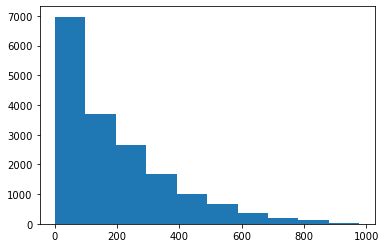

In [4]:
plt.hist(bikerent['cnt'])
plt.show()

In [5]:
bikerent.corr()['cnt']

season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [6]:
bikerent.drop(columns=['casual', 'registered'], inplace=True)

In [7]:
bikerent.corr()['cnt'].sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
hr            0.394071
atemp         0.400929
temp          0.404772
cnt           1.000000
Name: cnt, dtype: float64

The most explainable features are:
* Temperature
* Adjusted temperature
* Humidity

## Data manipulation

`Weathersit`, `Season` are two columns that needs to be one-hot encoded since the values there are rather nominal than ordinal and consequently not representable.

In [8]:
# Define a function to transform hours
def hours_trans(hour):
    if hour >=6 and hour <12:
        return 1 #Morning
    elif hour >=12 and hour <= 18:
        return 2 #Day
    elif hour >18 and hour < 24:
        return 3 #Evening
    else:
        return 4 #Night
    
bikerent['hr_label'] = bikerent['hr'].apply(hours_trans)
bikerent['hr_label'].value_counts(dropna=False) # Check

2    5103
1    4360
4    4276
3    3640
Name: hr_label, dtype: int64

In [9]:
bikerent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  cnt         17379 non-null  int64  
 14  hr_label    17379 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.1+ MB


In [10]:
bikerent.drop(columns=['dteday', 'atemp'], inplace=True)

In [11]:
bikerent.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,hr_label
instant,,,,,,,,,,,,,
1,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16,4
2,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40,4
3,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32,4
4,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13,4
5,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1,4


## Training the model

In [12]:
from sklearn.model_selection import train_test_split
train_bike, test_bike = train_test_split(bikerent, test_size=0.2, random_state=1)
train_bike_x = train_bike.drop(columns=['cnt'])
train_bike_y = train_bike['cnt']
test_bike_x = test_bike.drop(columns=['cnt'])
test_bike_y = test_bike['cnt']

We will train 4 models here:

* Linear regression
* Decision Trees
* Random Forests
* Support Vector Machine (SVM) Regressor

Our error metrics will be MAE (mean absolute error), since it clearly shows us how much our prediction deviates from the original value, and r2 score.

### Linear regression model

In [13]:
%%time
lr = LinearRegression()
lr.fit(train_bike_x, train_bike_y)
predictions_train = lr.predict(train_bike_x)
predictions_test = lr.predict(test_bike_x)
mae_train = mean_absolute_error(train_bike_y, predictions_train)
mae_test = mean_absolute_error(test_bike_y, predictions_test)
r2_train = r2_score(train_bike_y, predictions_train)
r2_test = r2_score(test_bike_y, predictions_test)
print(f"Train MAE for linear regression:{mae_train}")
print(f"Test MAE for linear regression:{mae_test}")
print(f"Train r2 score for linear regression:{r2_train}")
print(f"Test r2 score for linear regression:{r2_test}")

Train MAE for linear regression:97.66416880793031
Test MAE for linear regression:97.65786757675075
Train r2 score for linear regression:0.4879620833438335
Test r2 score for linear regression:0.49645872086204856
CPU times: user 31.2 ms, sys: 2.71 ms, total: 33.9 ms
Wall time: 13.1 ms


Linear regression with these features is not able to predict the renting count with an adequate accuracy.

### Decision tree

In [14]:
%%time
def tree_pred(df, min_samples_split=2, min_samples_leaf=1, max_depth=None, return_values=False):
    train_bike, test_bike = train_test_split(df, test_size=0.2, random_state=1)
    train_bike_x = train_bike.drop(columns=['cnt'])
    train_bike_y = train_bike['cnt']
    test_bike_x = test_bike.drop(columns=['cnt'])
    test_bike_y = test_bike['cnt']

    clf = DecisionTreeRegressor(criterion='absolute_error', max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=1)
    clf.fit(train_bike_x, train_bike_y)
    predictions_train = clf.predict(train_bike_x)
    predictions_test = clf.predict(test_bike_x)
    mae_train = mean_absolute_error(train_bike_y, predictions_train)
    mae_test = mean_absolute_error(test_bike_y, predictions_test)
    r2_train = r2_score(train_bike_y, predictions_train)
    r2_test = r2_score(test_bike_y, predictions_test)
    if return_values == False:
        print(f"Train MAE for decision tree:{mae_train}")
        print(f"Test MAE for decision tree:{mae_test}")
        print(f"Train r2 score for decision tree:{r2_train}")
        print(f"Test r2 score for decision tree:{r2_test}")
        print(f"The tree depth is:{clf.get_depth()}")
        print(f"The number of leafs is:{clf.get_n_leaves()}")  
    else:
        return mae_train, mae_test, r2_train, r2_test
    
tree_pred(bikerent)

Train MAE for decision tree:0.005538373013018773
Test MAE for decision tree:35.34953970080552
Train r2 score for decision tree:0.9999947222694915
Test r2 score for decision tree:0.8849338417491213
The tree depth is:34
The number of leafs is:13105
CPU times: user 7.72 s, sys: 40.3 ms, total: 7.77 s
Wall time: 7.22 s


We clearly see an overfitting when we use default parameters. This is expected when using Decision Trees.

There are three main ways to combat overfitting:

* "Prune" the tree after we build it to remove unnecessary leaves.
* Use ensembling to blend the predictions of many trees.
* Restrict the depth of the tree while we're building it.

Let's start with the last approach and reduce `min_samples_split` parameter, which is the minimum number of samples required to split an internal node.

In [15]:
%%time
tree_pred(bikerent, min_samples_split=10)

Train MAE for decision tree:14.13486297921312
Test MAE for decision tree:31.99626006904488
Train r2 score for decision tree:0.97310208211629
Test r2 score for decision tree:0.9083400462544642
The tree depth is:29
The number of leafs is:3073
CPU times: user 7.27 s, sys: 53.1 ms, total: 7.32 s
Wall time: 7.35 s


In [16]:
x = np.arange(2,40, 5)
r2_trains = []
r2_tests = []
for split in x:
    mae_train, mae_test, r2_train, r2_test = tree_pred(bikerent, min_samples_split=split, return_values=True)
    r2_trains.append(r2_train)
    r2_tests.append(r2_test)

Text(0, 0.5, 'r2 score')

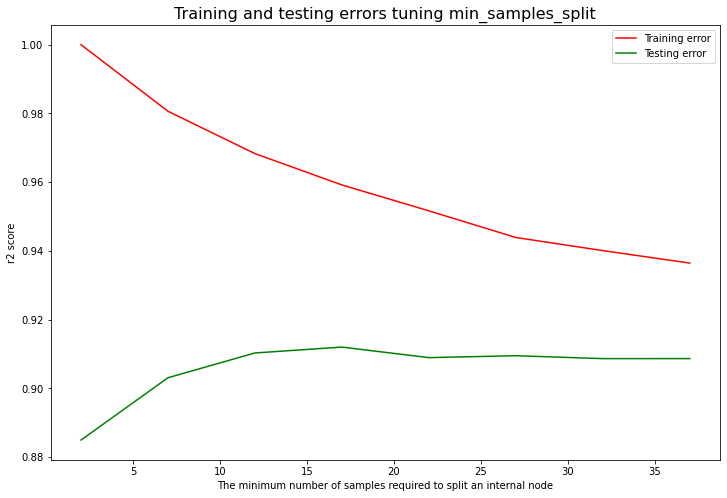

In [17]:
plt.figure(figsize=(12,8))
plt.plot(x, r2_trains, label='Training error', color='red')
plt.plot(x, r2_tests, label='Testing error', color='green')
plt.legend()
plt.title('Training and testing errors tuning min_samples_split', fontsize=16)
plt.xlabel('The minimum number of samples required to split an internal node')
plt.ylabel('r2 score')

We can clearly see that increasing `min_samples_split` to more than 15 will not lead to the further increase of test accuracy and will only lead to the decrease of train accuracy (so, we will have underfitting).

Now, let's try to reduce tree depth directly.

In [18]:
for leafd in np.arange(34, 20, -3):
    tree_pred(bikerent, max_depth=leafd)

Train MAE for decision tree:0.005538373013018773
Test MAE for decision tree:35.34953970080552
Train r2 score for decision tree:0.9999947222694915
Test r2 score for decision tree:0.8849338417491213
The tree depth is:34
The number of leafs is:13105
Train MAE for decision tree:0.009853988347838596
Test MAE for decision tree:35.495253164556964
Train r2 score for decision tree:0.9999926489145422
Test r2 score for decision tree:0.8839265402583335
The tree depth is:31
The number of leafs is:13098
Train MAE for decision tree:0.054808314752211755
Test MAE for decision tree:35.81415420023015
Train r2 score for decision tree:0.99994530511584
Test r2 score for decision tree:0.8831293218498234
The tree depth is:28
The number of leafs is:13029
Train MAE for decision tree:0.25483708552111056
Test MAE for decision tree:35.17836593785961
Train r2 score for decision tree:0.9995128131465345
Test r2 score for decision tree:0.8871518318863085
The tree depth is:25
The number of leafs is:12809
Train MAE for 

So, if we reduce the three depth without increasing the minimum number of samples required to split an internal node (`min_samples_split`) it will not reduce the total number of leafs much and will not improve the test r2 and MAE scores as a consequence. So, tuning this hyperparameter alone will not help us to overcome overfitting.

Let's finally try to tune `min_samples_leaf` which is the minimum number of samples required to be at a leaf node.

In [19]:
x = np.arange(1, 10, 2)
r2_trains = []
r2_tests = []
for split_leaf in x:
    mae_train, mae_test, r2_train, r2_test = tree_pred(bikerent, min_samples_split=15, min_samples_leaf=split_leaf, return_values=True)
    r2_trains.append(r2_train)
    r2_tests.append(r2_test)

Text(0, 0.5, 'r2 score')

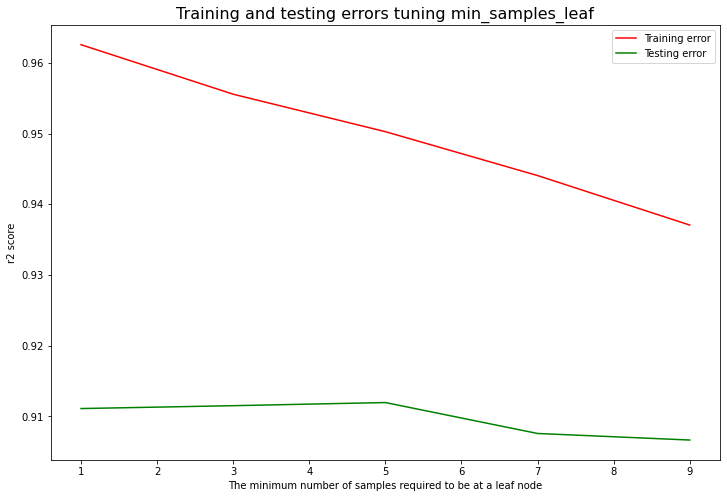

In [20]:
plt.figure(figsize=(12,8))
plt.plot(x, r2_trains, label='Training error', color='red')
plt.plot(x, r2_tests, label='Testing error', color='green')
plt.legend()
plt.title('Training and testing errors tuning min_samples_leaf', fontsize=16)
plt.xlabel('The minimum number of samples required to be at a leaf node')
plt.ylabel('r2 score')

We can see that the biggest testing accuracy is reached when `min_samples_leaf` is equal to 5.

And as a final hyperparameter to tune, let's consider another time `max_depth` which is a depth of a tree. Other hyperparameters will be fixed.

In [21]:
# Check the current tree depth given the other hyperparameters fixed.
tree_pred(bikerent, min_samples_split=15, min_samples_leaf=5, return_values=False)

Train MAE for decision tree:20.7520678990146
Test MAE for decision tree:31.351553509781358
Train r2 score for decision tree:0.9502629562022407
Test r2 score for decision tree:0.9119350172773292
The tree depth is:25
The number of leafs is:1575


In [22]:
x = np.arange(25, 6, -3)
r2_trains = []
r2_tests = []
for leafd in x:
    mae_train, mae_test, r2_train, r2_test = tree_pred(bikerent, max_depth=leafd, min_samples_split=15, min_samples_leaf=5, return_values=True)
    r2_trains.append(r2_train)
    r2_tests.append(r2_test)

Text(0, 0.5, 'r2 score')

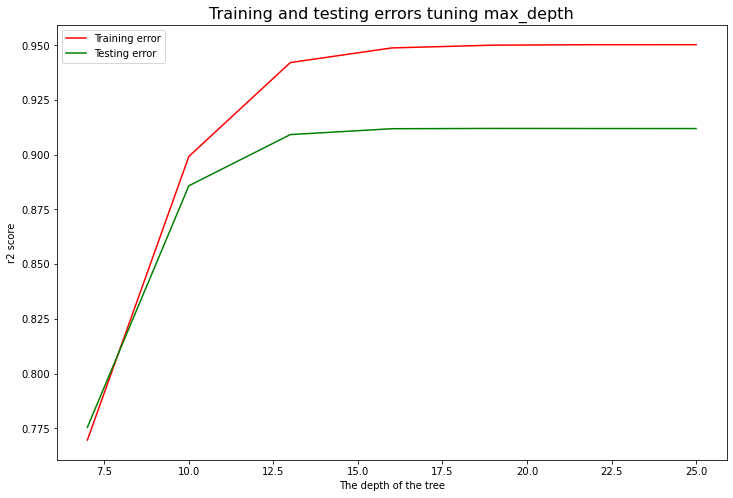

In [23]:
plt.figure(figsize=(12,8))
plt.plot(x, r2_trains, label='Training error', color='red')
plt.plot(x, r2_tests, label='Testing error', color='green')
plt.legend()
plt.title('Training and testing errors tuning max_depth', fontsize=16)
plt.xlabel('The depth of the tree')
plt.ylabel('r2 score')

We can clearly see that decreasing the depth of the tree does not help us to reach a better balance between training and testing accuracy. Therefore, we will keep it equal to 25 as default when other hyperparameters are tuned.

### Random forests

In [24]:
%%time
def rf_tree_pred(df, n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_depth=None, return_values=False):
    train_bike, test_bike = train_test_split(df, test_size=0.2, random_state=1)
    train_bike_x = train_bike.drop(columns=['cnt'])
    train_bike_y = train_bike['cnt']
    test_bike_x = test_bike.drop(columns=['cnt'])
    test_bike_y = test_bike['cnt']

    clf = RandomForestRegressor(criterion='absolute_error', n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=1)
    clf.fit(train_bike_x, train_bike_y)
    predictions_train = clf.predict(train_bike_x)
    predictions_test = clf.predict(test_bike_x)
    mae_train = mean_absolute_error(train_bike_y, predictions_train)
    mae_test = mean_absolute_error(test_bike_y, predictions_test)
    r2_train = r2_score(train_bike_y, predictions_train)
    r2_test = r2_score(test_bike_y, predictions_test)
    if return_values == False:
        print(f"Train MAE for decision tree:{mae_train}")
        print(f"Test MAE for decision tree:{mae_test}")
        print(f"Train r2 score for decision tree:{r2_train}")
        print(f"Test r2 score for decision tree:{r2_test}") 
    else:
        return mae_train, mae_test, r2_train, r2_test
    
rf_tree_pred(bikerent)

Train MAE for decision tree:11.185931094008488
Test MAE for decision tree:27.711809551208287
Train r2 score for decision tree:0.9886688763713223
Test r2 score for decision tree:0.9382344753205694
CPU times: user 27.3 s, sys: 18.5 ms, total: 27.3 s
Wall time: 27.3 s


The test accuracy has increased compared to decision tree model. Now, let's apply hyperparameters obtained from decision tree model.

In [25]:
rf_tree_pred(bikerent, n_estimators=10, min_samples_split=15, min_samples_leaf=5)

Train MAE for decision tree:22.543217291232107
Test MAE for decision tree:27.441196777905635
Train r2 score for decision tree:0.9534507847928028
Test r2 score for decision tree:0.937512047545694


In [26]:
x = np.arange(10, 31, 4)
r2_trains = []
r2_tests = []
for nestim in x:
    mae_train, mae_test, r2_train, r2_test = rf_tree_pred(bikerent, n_estimators=nestim, min_samples_split=15, min_samples_leaf=5, return_values=True)
    r2_trains.append(r2_train)
    r2_tests.append(r2_test)

Text(0, 0.5, 'r2 score')

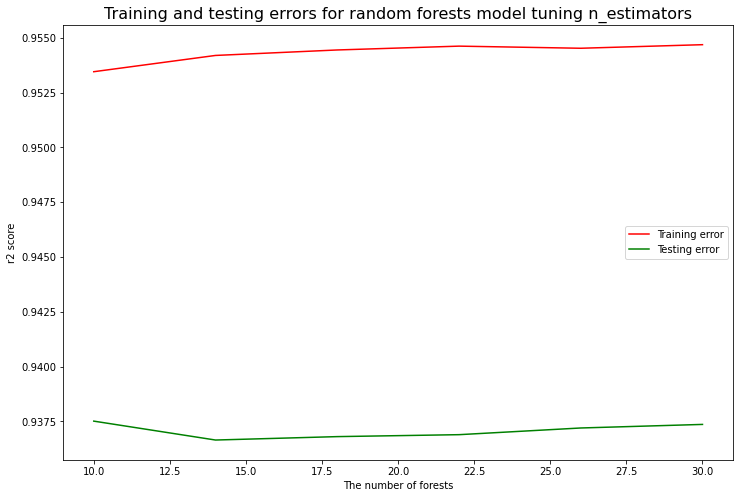

In [27]:
plt.figure(figsize=(12,8))
plt.plot(x, r2_trains, label='Training error', color='red')
plt.plot(x, r2_tests, label='Testing error', color='green')
plt.legend()
plt.title('Training and testing errors for random forests model tuning n_estimators', fontsize=16)
plt.xlabel('The number of forests')
plt.ylabel('r2 score')

As we can see, the increase of number of trees inside the forest does not contribute to the higher accuracy. Therefore, we can keep the default value (10 trees) for the faster speed of algorithm execution. 

Finally, let's use Support Vector Machine Regressor (SVR). 

### Support Vector Machine Regressor (SVR)

In [28]:
%%time
from sklearn.svm import SVR
SVR_rbf = SVR(kernel="rbf")
SVR_rbf.fit(train_bike_x, train_bike_y)
predictions_train = SVR_rbf.predict(train_bike_x)
predictions_test = SVR_rbf.predict(test_bike_x)
mae_train = mean_absolute_error(train_bike_y, predictions_train)
mae_test = mean_absolute_error(test_bike_y, predictions_test)
r2_train = r2_score(train_bike_y, predictions_train)
r2_test = r2_score(test_bike_y, predictions_test)
print(f"Train MAE for SVR:{mae_train}")
print(f"Test MAE for SVR:{mae_test}")
print(f"Train r2 score for SVR:{r2_train}")
print(f"Test r2 score for SVR:{r2_test}")

Train MAE for SVR:89.64733316743458
Test MAE for SVR:89.77809355803186
Train r2 score for SVR:0.37949845838752405
Test r2 score for SVR:0.38668793653836886
CPU times: user 33.4 s, sys: 225 ms, total: 33.7 s
Wall time: 33.7 s


MAE is lower than for linear regression (even though r2 score is worse). Generally, the accuracy of SVR is much worse than of decision tree and random forests model. However, we have to mention that support vector machines are very sensitive to data scaling. So, let's use a Pipeline from sklearn library and see if the accuracy will be improved.

In [29]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
SVR_rbf = Pipeline((
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf")),
))
SVR_rbf.fit(train_bike_x, train_bike_y)
predictions_train = SVR_rbf.predict(train_bike_x)
predictions_test = SVR_rbf.predict(test_bike_x)
mae_train = mean_absolute_error(train_bike_y, predictions_train)
mae_test = mean_absolute_error(test_bike_y, predictions_test)
r2_train = r2_score(train_bike_y, predictions_train)
r2_test = r2_score(test_bike_y, predictions_test)
print(f"Train MAE for SVR:{mae_train}")
print(f"Test MAE for SVR:{mae_test}")
print(f"Train r2 score for SVR:{r2_train}")
print(f"Test r2 score for SVR:{r2_test}")

Train MAE for SVR:83.08161043054751
Test MAE for SVR:84.44587448924318
Train r2 score for SVR:0.4679437061532955
Test r2 score for SVR:0.4666441568240387
CPU times: user 33.9 s, sys: 174 ms, total: 34.1 s
Wall time: 34.1 s


The accuracy has improved but not significantly. Finally, let's try to use linear model.

In [30]:
%%time
from sklearn.svm import LinearSVR
SVR_rbf = Pipeline((
    ("scaler", StandardScaler()),
    ("linear_svr", LinearSVR(C=1)),
))
SVR_rbf.fit(train_bike_x, train_bike_y)
predictions_train = SVR_rbf.predict(train_bike_x)
predictions_test = SVR_rbf.predict(test_bike_x)
mae_train = mean_absolute_error(train_bike_y, predictions_train)
mae_test = mean_absolute_error(test_bike_y, predictions_test)
r2_train = r2_score(train_bike_y, predictions_train)
r2_test = r2_score(test_bike_y, predictions_test)
print(f"Train MAE for SVR:{mae_train}")
print(f"Test MAE for SVR:{mae_test}")
print(f"Train r2 score for SVR:{r2_train}")
print(f"Test r2 score for SVR:{r2_test}")

Train MAE for SVR:92.88275453368028
Test MAE for SVR:93.85477550360278
Train r2 score for SVR:0.42238050430080554
Test r2 score for SVR:0.4243119960980669
CPU times: user 31.8 ms, sys: 2.41 ms, total: 34.3 ms
Wall time: 23.7 ms


As expected, linear model did not give better results than a model with rbf kernel. As a conclusion, we can claim that SVM is not the best algorithm for this particular data.

## Conclusions

In this project we tried to predict the number of bike rentals for each hour during the day, given the information about different calendar and weather particularities. After a short data processing and feature engineering we trained 3 regression models:

* Linear regression
* Decision tree regressor
* Random forests regressor
* SVM regressor

As a result of the analysis, we can conclude that the random forests algorithm is the most accurate for the given task and data. The results of the best model (10 forests) are the following:

* 27.44 in terms of MAE (mean average error)
* 0.937 r2 score